In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import ipywidgets as widgets
from IPython.display import display
from scipy.stats import pearsonr

from brian2 import *
from brian2tools import *

style.use('seaborn-v0_8-colorblind')
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

import logging
logging.getLogger('brian2').setLevel(logging.WARNING)
logging.getLogger().setLevel(logging.WARNING)

WARNING    /Users/administrator/GRS_2025_spiking_EI_workshop/venv/lib/python3.13/site-packages/brian2tools/__init__.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
 [py.warnings]
  from pkg_resources import get_distribution, DistributionNotFound



# 1. Neuron and synapse model

### 1.1 Neuron model

In this tutorial we will use a **Leaky-Integrate and Fire (LIF)** neuron. The mathematical definition of the LIF is the following:

\begin{align*}
C_m \frac{dv}{dt} = g_l \cdot (E_L - v)+ I_{\eta} \end{align*}

where:
- $C_m$ is the capacitance of the membrane
- $g_l$ the leak conductance
- $I_{\eta} $ is a noisy current representing background activity

We implement this model using [BRIAN](https://brian2.readthedocs.io/en/stable/). The slider in the following plot allows you to increase and decrease the variance $I_\sigma$ of the noisy background current. A red dot indicates that the neuron spikes.


In [3]:
# Set neuron parameters
E_l = -79 * mV
v_spike = -49 * mV
C_m = 180 * pF
g_l = 18 * nS

I_mu = 0 * pA
# These parameters yield a membrane time constant of 10 ms
# Constant input needs to be ~540 pA to induce regular spiking

# Neuron equations
LIF_eq_simple = '''
dv/dt = (g_l * (E_l - v) + I_eta) / C_m : volt (unless refractory)
dI_eta/dt = (I_mu - I_eta) / tau_noise + I_sigma * xi * tau_noise**-0.5 : ampere
I_sigma : ampere
tau_noise : second
'''

# Define the neurons. Syntax: NeuronGroup(number of neurons, differential equation)
# You can also define further properties like method, threshold, reset, refactory period etc.

def run_brian_neurons(strength):

    start_scope()  # Clear previous BRIAN objects
    
    LIF_neuron = NeuronGroup(
        1, LIF_eq_simple,
        threshold='v > v_spike',
        reset='v = E_l',
        refractory=3 * ms,
        method='euler' 
    )
    
    LIF_neuron.I_sigma = strength * pA
    LIF_neuron.tau_noise = C_m / g_l
    LIF_neuron.v = E_l  # Initialise the membrane potential to its starting value

    # To store activity, we need to define monitors
    spikemon = SpikeMonitor(LIF_neuron)
    statemon = StateMonitor(LIF_neuron, ['v', 'I_eta'], record=True, dt=1 * ms)

    run(3000 * ms, report=None)

    return spikemon, statemon


def update_brianplot(noise_sig):
    spikemon, statemon = run_brian_neurons(noise_sig)

    fig, ax = plt.subplots(2, 1, figsize=(6, 6))
    
    ax[0].plot(statemon.t / ms, statemon.I_eta[0] / pA)
    ax[0].set_ylabel(r'Input current [pA]')
    ax[0].grid(True)

    ax[1].plot(statemon.t / ms, statemon.v[0] / mV)
    ax[1].scatter(spikemon.t / ms, np.full_like(spikemon.t, v_spike / mV + 1), color='r', s=10, label='Spikes') # We plot indicators for the spike a bit above the spike threshold. If you want to plot a spike raster you can use SpikeMonitor
    ax[1].set_xlabel('Time [ms]')
    ax[1].set_ylabel('Membrane voltage [mV]')
    ax[1].grid(True)

    ax[0].set_title('LIF Neuron')
    fig.tight_layout()
    plt.show()

# Create a slider
slider = widgets.FloatSlider(value=250, min=100, max=1000, step=50, description="I_σ [pA]:", continuous_update=False)

# Link slider to update function
interactive_plot = widgets.interactive_output(update_brianplot, {'noise_sig': slider})

# Display slider and interactive plot
display(slider, interactive_plot)


FloatSlider(value=250.0, continuous_update=False, description='I_σ [pA]:', max=1000.0, min=100.0, step=50.0)

Output()

### 1.2 Synapse model

**Conductance-based synapses** model the synaptic current as a function of the momentary membrane potential. The conductance $g$ increases whenever a presynaptic spike occurs and then decays exponentially back to baseline. The synaptic current $ I^{syn} $ received by a postsynaptic neuron is given by:

\begin{align*} \frac{dg}{dt} &= - \frac{g}{\tau_{syn}} + s \\ I^{syn}(t) &=  w \cdot g(t)\cdot (v(t) - E_{e,i})
 \end{align*}

where:
- $s=1$ when a presynaptic spike occurs and $s=0$ otherwise
- $w$ is the synaptic weight between the presynaptic and postsynaptic neuron
- $E_{e, i}$ is the synaptic reversal potential.

When many synapses converge onto a postsynaptic neuron, the total synaptic current is the sum over all individual currents, each weighted by their respective synaptic strength. Luckily, BRIAN handles this automatically.

In BRIAN, synapses are defined similarly to Neuron groups. The typical syntax is ```Synapse(Pre_Neuron_Group, Post_Neuron_Group, on_pre, on_post ...)```. 

The ```on_pre``` and ```on_post``` arguments are event-triggered operations. This means that whenever a spike is detected in the presynaptic population, the operation defined by ```on_pre``` is carried out.

In the following example, we use a regularly spiking neuron from a ```SpikeGeneratorGroup``` as the presynaptic source.

In [4]:
# Synaptic reversal potentials
E_e = 0 * mV
E_i = -80 * mV

# Postsynaptic neuron model with excitatory input
LIF_eq_inp = '''
dv/dt = (g_l * (E_l - v) - g_e * (v - E_e)) / C_m : volt (unless refractory)
dg_e/dt = -g_e / tau_syn : siemens
tau_syn : second
'''

# Synapse model: static weight
syn_eq = '''w : siemens'''  # Our synapse only transmit activity, it is not plastic - so we only need one parameter w
on_pre_eq = '''g_e += w'''  # Whenever a presynaptic spike occurs, the conductance is increased by w. Here, we only look at an excitatory synapse; change all _e to _i to look at the effect of an inhibitory synapse

In [5]:
def run_connected_neurons(syn_strength):
    start_scope()  # Clean Brian2 workspace

    # Presynaptic neuron spikes every 10 ms
    N_pre = SpikeGeneratorGroup(1, np.zeros(10, dtype=int), np.arange(0, 100, 10) * ms)
    
    # Postsynaptic neuron with conductance-based input
    N_post = NeuronGroup(
        1, LIF_eq_inp,
        threshold='v > v_spike',
        reset='v = E_l',
        refractory=3 * ms,
        method='euler'
    )
    N_post.v = E_l
    N_post.tau_syn = 10 * ms

    # Synapse setup
    curr_syn = Synapses(N_pre, N_post, syn_eq, on_pre=on_pre_eq)
    curr_syn.connect('i == j')
    curr_syn.w = syn_strength * nS

    # Monitors
    pre_s = SpikeMonitor(N_pre)
    post_s = SpikeMonitor(N_post)
    record_v = StateMonitor(N_post, 'v', record=True, dt=1 * ms)

    run(120 * ms, report=None)

    return pre_s, post_s, record_v

In [6]:
def update_conductanceplot(w):
    spike_pre, spike_post, v = run_connected_neurons(w)

    fig, ax = plt.subplots(figsize=(6, 3))
    ax.plot(v.t / ms, v.v[0] / mV, color='b')
    ax.scatter(spike_pre.t / ms, np.full_like(spike_pre.t, v_spike / mV + 1), color='r', s=20, label='Pre')
    ax.scatter(spike_post.t / ms, np.full_like(spike_post.t, v_spike / mV + 2), color='b', s=20, label='Post')
    
    ax.set_xlabel('Time [ms]')
    ax.set_ylabel('Membrane voltage [mV]')
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', frameon=False)
    fig.tight_layout()
    plt.show()

# Create a slider for synaptic weight
slider = widgets.FloatSlider(value=10, min=0, max=20, step=1, description="w:", continuous_update=False)

# Use interactive to update the plot when the slider moves
interactive_plot = widgets.interactive_output(update_conductanceplot, {'w': slider})

# Display slider and interactive plot
display(slider, interactive_plot)

FloatSlider(value=10.0, continuous_update=False, description='w:', max=20.0, step=1.0)

Output()

# 2. Activity regimes in networks of spiking neurons

So far, we have only considered single neurons. In this section, we define an excitatory and an inhibitory neural population which are randomly connected with a connection probability of 10%. This results in four types of synaptic connections: E→E, E→I, I→E, and I→I.

### 2.1 Coefficient of variation 

A common way to measure the temporal structure of neural activity is the **Coefficient of Variation (CV)** of the inter-spike intervals (ISI):

\begin{align*}CV = \frac{\sigma}{\mu} \end{align*}

For neural data, this is calculated based on the ISIs of spike trains. A value of $CV = 1$ indicates irregular or Poisson-like spiking. If $CV > 1$, the neuron shows more irregularity than a Poisson process, whereas a $CV < 1$ indicates more regular firing. A regularly spiking neuron such as an LIF neuron driven by constant input typically has $CV = 0$. 

The cell below defines a function that takes spike times and computes the CV of the inter-spike intervals.

In [7]:
def CV_calc(spike_mon):
    # Compute inter-spike intervals (ISIs)
    trains = spike_mon.spike_trains()
    all_isis = [np.diff(trains[i] / ms) for i in trains if len(trains[i]) > 1]
    
    if not all_isis:
        return np.nan  # No ISIs to compute

    ISIs = np.concatenate(all_isis)
    mean = np.nanmean(ISIs)
    sd = np.nanstd(ISIs)
    
    return sd / mean if mean > 0 else np.nan

### 2.2. Spike correlelogram 

Another way to characterise the activity of spiking neural networks is by assessing the **degree of synchronicity** across neurons. Are multiple neurons active at the same time?

To quantify synchronicity, we compute the **spike correlogram**. This is defined as the distribution of all pairwise correlation coefficients between spike trains:

\begin{align*}CC(i,j) = \rho(s^i, s^j)  = \frac{\sum_t (s^i_t - \mu(s^i))(s^j_t - \mu(s^j))}{\sqrt{\sum_t(s^i_t - \mu(s^i))^2}\sqrt{\sum_t(s^j_t - \mu(s^j))^2}}\end{align*}

Where:
- $s^i$ is the full spike train of neuron i 
- $s^i_t = 1$ if neuron $i$ spikes at timepoint $t$, and 0 otherwise

In practice, this is implemented using ```numpy.corrcoef```, which computes the full cross-correlation matrix between spike trains.

Note: we only take into account active neurons. The correlation of a constant array (e.g., all zeros for silent neurons or all ones for persistently active neurons) is undefined.

In [8]:
def CC_calc(spike_mon, sim_time, N, dt=1):
    trains = spike_mon.spike_trains()
    num_bins = int(sim_time / dt)
    raster = np.zeros((N, num_bins))

    for i in range(N):
        if i in trains:
            spike_bins = (trains[i] / ms / dt).astype(int)
            spike_bins = spike_bins[spike_bins < num_bins]  # avoid out-of-bounds
            raster[i, spike_bins] = 1.0

    # Exclude neurons with constant spike trains (all 0s or all 1s)
    spike_sums = np.sum(raster, axis=1)
    include = np.where((spike_sums > 0) & (spike_sums < num_bins))[0]

    if len(include) < 2:
        return np.array([])  # Not enough data for pairwise correlation

    CCs = np.corrcoef(raster[include])
    return CCs[np.triu_indices_from(CCs, k=1)]  # return upper triangle (excluding diagonal)


### 2.3. Network regimes: sychrony and irregularity

A network can be synchronous yet exhibit **irregular** spiking activity. On the other hand, neurons may spike **highly regularly**, but at different **phases**, resulting in **asynchronous** activity. Based on these distinctions, we can classify network activity into four canonical regimes:

- **Synchronous Regular (SR)**
- **Asynchronous Regular (AR)**
- **Synchronous Irregular (SI)**
- **Asynchronous Irregular (AI)**

The **SR and SI** regimes are computationally unfavorable. In these states, all neurons respond similarly to any given stimulus, meaning the information content is similar to that of a single regular spiking neuron. Such homogeneity is often viewed as **pathological**, as the network fails to differentiate between inputs.

The **AR regime** offers better representational capacity. Here, information can be distributed across distinct firing phases or frequencies among neurons or subgroups. But it still does not take advantage of the full expressive potential of a spiking network.

The **AI regime** is regarded as the most computationally powerful. Here, neurons fire irregularly and independently, allowing complex, stimulus-specific patterns of activity across the network. This regime supports rich dynamics and heterogeneous responses, making it ideal for neural coding and network-level computation.

These distinctions and their theoretical basis are thoroughly explored in:

> **Brunel, N.** (2000). *Dynamics of sparsely connected networks of excitatory and inhibitory spiking neurons*. Journal of Computational Neuroscience, 8, 183–208.


# 3. The more the merrier: the importance of network size

Activity in spiking neural networks is often driven by coincident presynaptic activity. A presynaptic spike only has a brief time window in which it can significantly depolarize the postsynaptic membrane. Thus, multiple presynaptic spikes must occur together in order to elicit a postsynaptic spike.

Whether this excitation arises from one highly active presynaptic neuron or from the synchronous firing of several less active neurons does not matter greatly to the postsynaptic neuron - it's the timing and convergence that matter. However, the larger the network, the greater the probability that neurons will be spontaneously coactivate and drive postsynaptic activity.

To investigate this effect, we will use a standard **excitatory–inhibitory (EI) network** with a connection probability of 20%. Spontaneous activity is induced using background noise, as in the earlier LIF model. Each neuron has a spontaneous firing rate of approximately 0.6 Hz.

You can manipulate the number of excitatory neurons $N_E$ and inhibitory neurons $N_I$ using the input fields in the interactive simulation below. Synaptic weights are automatically scaled to compensate for changes in total population size, maintaining consistent postsynaptic input statistics.

![title](network.png)

In [9]:
# Network parameters
tau_noise = C_m / g_l
I_sigma = 600 * pA  # ~0.6 Hz background activity per neuron
I_mu = 0 * pA

tau_syn_e = 5 * ms
tau_syn_i = 10 * ms
w_syn = 7 * nS

N_E = 4000
N_I = 1000
p_conn = 0.2  # Connection probability

LIF_eq = '''
dv/dt = (g_l * (E_l - v) - g_e * (v - E_e) - g_i * (v - E_i) + I_eta) / C_m : volt (unless refractory)
dI_eta/dt = (I_mu - I_eta) / tau_noise + I_sigma * xi * tau_noise**-0.5 : ampere
dg_e/dt = -g_e / tau_syn_e : siemens
dg_i/dt = -g_i / tau_syn_i : siemens
'''

on_pre_E = 'g_e += w'  # Automatically understood to be postsynaptic
on_pre_I = 'g_i += w'

def run_connected_network(N_e, N_i, fac_ee, fac_ei, fac_ie, fac_ii):
    seed(5)
    start_scope()
    
    # We have one big population which we subdivide into one excitatory and one inhibitory
    N_total = N_e + N_i
    N_Pop = NeuronGroup(N_total, LIF_eq,
                        threshold='v > v_spike',
                        reset='v = E_l',
                        refractory=3 * ms,
                        method='euler')
    
    # Initial conditions around rest ±15 mV
    N_Pop.v = (np.random.rand(N_total) * 15 - 79) * mV + E_l
    
    # Connectivity
    EE = Synapses(N_Pop[:N_e], N_Pop[:N_e], syn_eq, on_pre=on_pre_E)
    EI = Synapses(N_Pop[:N_e], N_Pop[N_e:], syn_eq, on_pre=on_pre_E)
    IE = Synapses(N_Pop[N_e:], N_Pop[:N_e], syn_eq, on_pre=on_pre_I)
    II = Synapses(N_Pop[N_e:], N_Pop[N_e:], syn_eq, on_pre=on_pre_I)

    for syn, fac, N in zip([EE, EI, IE, II],
                           [fac_ee, fac_ei, fac_ie, fac_ii],
                           [N_e, N_e, N_i, N_i]):
        syn.connect(p=p_conn)
        syn.w = w_syn / np.log(N) * fac

    # Monitors
    spike_mon = SpikeMonitor(N_Pop)
    s_E = SpikeMonitor(N_Pop[:N_e])
    s_I = SpikeMonitor(N_Pop[N_e:])
    r_E = PopulationRateMonitor(N_Pop[:N_e])
    r_I = PopulationRateMonitor(N_Pop[N_e:])

    run(10 * second, report=None)

    return spike_mon, s_E, s_I, r_E, r_I

In [10]:
def update_networkplot(n_E, n_I, fac_EE, fac_EI, fac_IE, fac_II, title):
    with output:
        output.clear_output(wait=True)

        fig, ax = plt.subplots(1, 3, figsize=(18, 4))

        spike_tot, spikes_E, spikes_I, rate_e, rate_i = run_connected_network(
            n_E, n_I, fac_EE, fac_EI, fac_IE, fac_II
        )

        # Raster
        ax[0].scatter(spikes_E.t, spikes_E.i, color='r', marker='|', label='E')
        ax[0].scatter(spikes_I.t, spikes_I.i + n_E, color='b', marker='|', label='I')
        ax[0].set_xlim(9, 10)
        ax[0].set_xlabel('t [s]')
        ax[0].set_ylabel('Neuron index')

        # Rates
        ax[1].plot(rate_e.t / second, rate_e.smooth_rate(window='flat', width=1 * second) / Hz, color='r', label='E')
        ax[1].plot(rate_i.t / second, rate_i.smooth_rate(window='flat', width=1 * second) / Hz, color='b', label='I')
        ax[1].set_xlabel('t [s]')
        ax[1].set_ylabel('Firing rate [Hz]')
        ax[1].legend(loc='upper right', frameon=False)
        ax[1].grid(True)

        # Correlation histogram
        CC_vals = CC_calc(spike_tot, 10000, n_E + n_I)
        ax[2].hist(CC_vals, bins=100)
        ax[2].set_xlim(-1.05, 1.05)
        ax[2].set_xlabel('CC(i, j)')
        ax[2].set_ylabel('Count')

        # Title
        CV_val = CV_calc(spike_tot)
        fig.suptitle(f'{title}       CV: {CV_val:.2f}')
        fig.tight_layout()
        plt.show()

# Widgets
run_button = widgets.Button(description="Run simulation")

ne_input = widgets.IntText(value=400, description='N_E:', step=1)
ni_input = widgets.IntText(value=100, description='N_I:', step=1)

def on_button_click(b):
    update_networkplot(
        ne_input.value, ni_input.value,
        fac_EE=1, fac_EI=1, fac_IE=4, fac_II=4,
        title=f'$N_E$={ne_input.value}, $N_I$={ni_input.value}'
    )

output = widgets.Output()
run_button.on_click(on_button_click)

# Display UI
display(widgets.VBox([ne_input, ni_input, run_button, output]))

You should observe that:

- The **more neurons** in the network, the greater the **overall activity** due to increased synaptic interactions
- The **more excitatory neurons**, the higher the degree of synchonicity

In the following, we explore how the **relative strength of excitatory and inhibitory synapses** influence the network dynamics.

# 4. EI balance and network synchronization

**Excitatory–inhibitory (EI) balance** is a foundational principle in neural network dynamics, and it can apply across multiple scales:

- **Broad or global EI balance** typically refers to firing rates. It means that rates co-vary over time - e.g., an increase in excitation is accompanied by a compensatory increase in inhibition.

- **Tight EI balance** refers to this co-variation on short timescales (on the order of milliseconds). Most often it refers to the instantaneous firing rates or precise spike timing of excitatory and inhibitory neurons.

- **Local EI balance** usually refers to synaptic balance at the level of individual neurons. A neuron is considered locally balanced if it receives comparable levels of excitatory and inhibitory input over time.

**Synchronization** is closely linked to **local EI balance**. Imbalances increase the risk of excessive synchrony and pathological dynamics.

In the simulation below, you can directly manipulate local EI balance to see how it shapes network activity. The parameters $g_{EE}, g_{EI}, g_{IE}$ and $g_{II}$ control the multiplicative strength of each synapse type.

In [11]:
# Sliders for synaptic strength modifiers
ee_input = widgets.FloatText(
    value=1,
    description='g_EE:',
    step=0.01
)

ei_input = widgets.FloatText(
    value=1,
    description='g_EI:',
    step=0.01
)

ie_input = widgets.FloatText(
    value=4,
    description='g_IE:',
    step=0.01
)

ii_input = widgets.FloatText(
    value=4,
    description='g_II:',
    step=0.01
)

# Update function for custom weights
def on_button_click(b):
    title = (f'g_{{EE}}$ = {ee_input.value}; '
             f'$g_{{EI}}$ = {ei_input.value}; '
             f'$g_{{IE}}$ = {ie_input.value}; '
             f'$g_{{II}}$ = {ii_input.value}')
    
    update_networkplot(
        N_E, N_I,
        ee_input.value,
        ei_input.value,
        ie_input.value,
        ii_input.value,
        title
    )

run_button.on_click(on_button_click)

# Display UI
display(widgets.VBox([
    ee_input, ei_input, ie_input, ii_input,
    run_button, output
]))


You should observe that:
- when the **I→E** synapse is weak, the network synchronises
- when the **I→E** synapse is strong, the network desynchronises

# 5. Inhibitory plasticity can desynchronise recurrent networks

The following results and insights about the role of inhibitory plasticity are based on the work of:

> **Vogels, T. P., Sprekeler, H., Zenke, F., Clopath, C., & Gerstner, W.** (2011). *Inhibitory plasticity balances excitation and inhibition in sensory pathways and memory networks.* Science, 334(6062), 1569–1573.

The inhibitory synaptic plasticity rule used here follows a **symmetric, LTP-dominated spike-timing-dependent plasticity** (STDP) kernel. Specifically:

- **Pre–post spike pairings** with short inter-spike intervals lead to **long-term potentiation (LTP)** of the inhibitory synapse.
- Each **presynaptic spike** also induces **long-term depression (LTD)**, acting as a counterbalance.


\begin{align}
\Delta w = \eta \cdot pre \cdot post - \alpha \cdot pre
\end{align}


We first implement a synapse and this plasticity rule to visualize the shape of the STDP kernel. You can explore how the kernel changes by adjusting:
- the time constant $\tau_{STDP}$
- and the presynaptic depression factor $\alpha$

In [12]:
# Equations and updates for the STDP inhibitory plasticity rule
syn_eq = '''
    w : 1
    dapre/dt = -apre / tau_stdp : 1 (event-driven)
    dapost/dt = -apost / tau_stdp : 1 (event-driven)
'''

onpre = '''
    apre += 1
    w = clip(w + (apost - alpha) * eta, 0, wmax)
'''

onpost = '''
    apost += 1
    w = clip(w + apre * eta, 0, wmax)
'''

# Parameters
N = 200
eta = 0.1
wmax = 2
tmax = 100 * ms

def run_sim(tau, alpha_v):
    with output:
        output.clear_output(wait=True)
        start_scope()
        seed(42)  # ensure deterministic STDP kernel

        tau_stdp = tau * ms
        alpha = alpha_v

        G = NeuronGroup(N, 'tspike : second', threshold='t > tspike', refractory=200*ms)
        H = NeuronGroup(N, 'tspike : second', threshold='t > tspike', refractory=200*ms)

        G.tspike = 'i * tmax / (N - 1)'
        H.tspike = '(N - 1 - i) * tmax / (N - 1)'

        S = Synapses(G, H, syn_eq, on_pre=onpre, on_post=onpost)
        S.connect(j='i')
        S.w = 1

        run(tmax + 1 * ms)

        fig, ax = plt.subplots(figsize=(3, 3))
        ax.plot((H.tspike - G.tspike) / ms, S.w - 1)
        ax.axhline(0, ls=':', c='grey')
        ax.axvline(0, ls=':', c='grey')
        ax.set_xlabel(r'$\Delta t$ (ms)')
        ax.set_ylabel(r'$\Delta w$')
        plt.tight_layout()
        plt.show()

# Input widgets
tau_input = widgets.IntText(
    value=20,
    description='τ (STDP):',
    step=1
)

alpha_input = widgets.FloatText(
    value=0.2,
    description='α (LTD):',
    step=0.01
)

# Run button
run_button = widgets.Button(description="Calculate STDP kernel")

# Link button to function
run_button.on_click(lambda b: run_sim(tau_input.value, alpha_input.value))

# Display
display(widgets.VBox([tau_input, alpha_input, run_button, output]))


### 5.1 Desynchronising Recurrent Activity

We learned that weak inhibition drives the network into an **un­favour­able synchronous regime**. Here we demonstrate that **plastic I→E synapses** which follow the symmetric, LTP-dominated inhibitory STDP rule can *self-tune* the network into the desirable **asynchronous irregular (AI)** state.

We'll simulate the network in two phases:
- No plasticity for 1 second to observe the default (pathological) dynamics.
- Plasticity enabled for 9 seconds to observe how the network transitions into the AI regime.

Only the I→E synapses are plastic. We monitor both spike trains and firing rates, and track the evolution of 10 representative I→E synaptic weights.

![title](plastic_network.png)

In [21]:
# Network configuration

N_E = 4000
N_I = 1000
C_m = 180 * pF
g_l = 18 * nS
E_l = -79 * mV
E_e = 0 * mV
E_i = -80 * mV
v_spike = -49 * mV

tau_noise = C_m / g_l
I_sigma = 400 * pA
I_mu = 0 * pA

tau_syn_e = 5 * ms
tau_syn_i = 10 * ms
tau_stdp = 20 * ms
eta = 0.01
alpha = 3 * Hz * tau_stdp * 2  # target rate x window x scale
wmax = 100
p_conn = 0.02

# Neuron and synapse models

LIF_eq = '''
dv/dt = (g_l * (E_l - v) - g_e * (v - E_e) - g_i * (v - E_i) + I_eta + I_e) / C_m : volt (unless refractory)
dI_eta/dt = (I_mu - I_eta) / tau_noise + I_sigma * xi * tau_noise**-0.5 : ampere
dg_e/dt = -g_e / tau_syn_e : siemens
dg_i/dt = -g_i / tau_syn_i : siemens
I_e : ampere
'''

syn_eq_plastic = '''
w : 1
dapre/dt = -apre / tau_stdp : 1 (event-driven)
dapost/dt = -apost / tau_stdp : 1 (event-driven)
'''

syn_eq_nonplastic = 'w : 1'

on_pre_IE = '''
g_i += w * nS
apre += 1
w = clip(w + (apost - alpha) * eta, 0, wmax)
'''

on_post_IE = '''
apost += 1
w = clip(w + apre * eta, 0, wmax)
'''

on_pre_E = 'g_e += w * 3 * nS'
on_pre_I = 'g_i += w * 30 * nS'


# Construct the network
start_scope()
seed(5)

N_total = N_E + N_I
N_Pop = NeuronGroup(N_total, LIF_eq, threshold='v > v_spike', reset='v = E_l',
                    refractory=3 * ms, method='euler')
N_Pop.v = (np.random.rand(N_total) * 15 - 79) * mV

# Define the synapses
EE = Synapses(N_Pop[:N_E], N_Pop, syn_eq_nonplastic, on_pre=on_pre_E)
EE.connect(p=p_conn)
EE.w = 1

IE = Synapses(N_Pop[N_E:], N_Pop[:N_E], syn_eq_plastic, on_pre=on_pre_IE, on_post=on_post_IE)
IE.connect(p=p_conn)
IE.w = 0.0001  # Start with very weak inhibition

II = Synapses(N_Pop[N_E:], N_Pop[N_E:], syn_eq_nonplastic, on_pre=on_pre_I)
II.connect(p=p_conn)
II.w = 1

# Save initial weight state for visualization later
IE_weights_init = np.full((N_I, N_E), np.nan)
IE_weights_init[IE.i[:], IE.j[:]] = IE.w[:]


# Monitoring
s_E  = SpikeMonitor(N_Pop[:N_E])
s_I  = SpikeMonitor(N_Pop[N_E:])
r_E  = PopulationRateMonitor(N_Pop[:N_E])
r_I  = PopulationRateMonitor(N_Pop[N_E:])
ws   = StateMonitor(IE, 'w', record=np.arange(10), dt=1*ms)

# Simulation: Phase 1 (No plasticity)
eta = 0
run(1 * second, report=None)

# Simulation: Phase 2 (Plasticity)
eta = 0.01
run(9 * second, report=None)


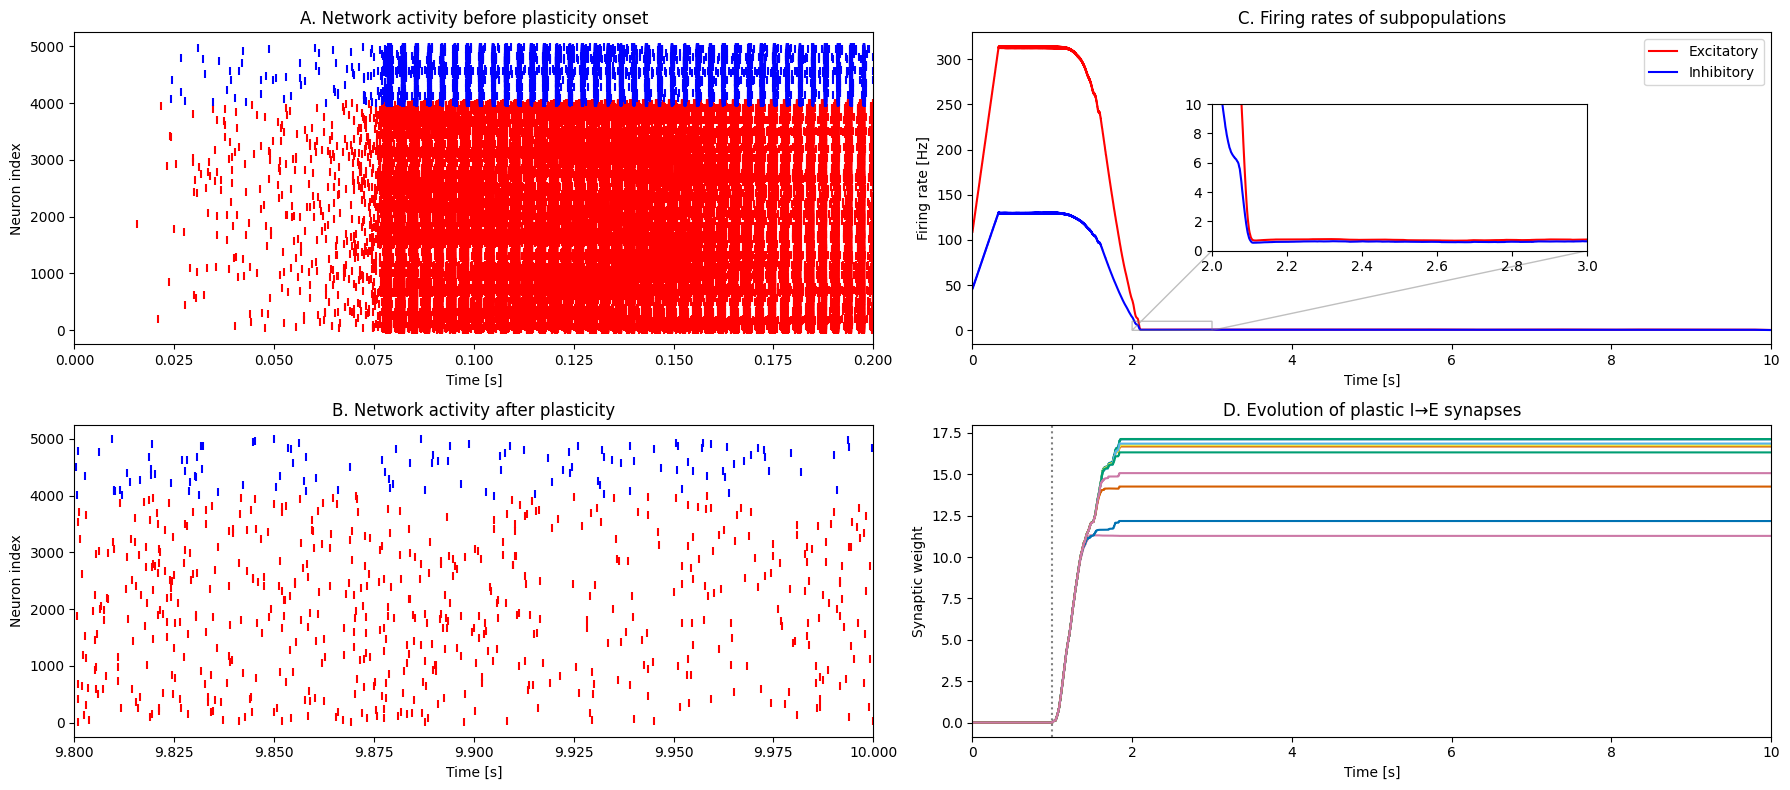

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(18, 8))

# Extract smoothed rates
def smooth(rate_monitor):
    return rate_monitor.smooth_rate(window='flat', width=0.5 * second) / Hz

# Raster plots before/after plasticity
def plot_raster(ax_raster, t_window, title):
    ax_raster.scatter(s_E.t / second, s_E.i, color='r', marker='|', label='E')
    ax_raster.scatter(s_I.t / second, s_I.i + N_E, color='b', marker='|', label='I')
    ax_raster.set_xlim(*t_window)
    ax_raster.set_xlabel('Time [s]')
    ax_raster.set_ylabel('Neuron index')
    ax_raster.set_title(title)

plot_raster(ax[0, 0], (0, 0.2), 'A. Network activity before plasticity onset')
plot_raster(ax[1, 0], (9.8, 10), 'B. Network activity after plasticity')

# Population firing rates
ax[0, 1].plot(r_E.t / second, smooth(r_E), color='r', label='Excitatory')
ax[0, 1].plot(r_I.t / second, smooth(r_I), color='b', label='Inhibitory')
ax[0, 1].set_xlim(0, 10)
ax[0, 1].set_xlabel('Time [s]')
ax[0, 1].set_ylabel('Firing rate [Hz]')
ax[0, 1].set_title('C. Firing rates of subpopulations')
ax[0, 1].legend()

# Zoomed inset on rate transitions
x1, x2, y1, y2 = 2, 3, 0, 10
axins = ax[0, 1].inset_axes([.3, .3, .47, .47], xlim=(x1, x2), ylim=(y1, y2))
axins.plot(r_E.t / second, smooth(r_E), color='r')
axins.plot(r_I.t / second, smooth(r_I), color='b')
ax[0, 1].indicate_inset_zoom(axins)

# Synaptic weight evolution
for i in range(10):
    ax[1, 1].plot(ws.t / second, ws.w[i])
ax[1, 1].axvline(1, ls=':', color='grey', label='Plasticity onset')
ax[1, 1].set_xlim(0, 10)
ax[1, 1].set_xlabel('Time [s]')
ax[1, 1].set_ylabel('Synaptic weight')
ax[1, 1].set_title('D. Evolution of plastic I→E synapses')

fig.tight_layout()
plt.show()

### 5.2. Stabilising inserted memory engrams via inhibitory plasticity. 

We used inhibitory plasticity to suppress global synchrony and steer the network into an **asynchronous irregular (AI)** regime. In this section, we test the **robustness** of this regime by challenging the network with structured excitatory inputs - **memory engrams**.

A **memory engram** is a subset of neurons with strengthened mutual connectivity, forming an assembly that can be reactivated by partial input. To mimic engram formation, we manually increase the **E→E synaptic weights** within two selected subpopulations.

However, increasing excitatory weights disrupts the EI balance and can lead to pathological reverberations - spontaneous self-activations of the engram that propagate through the network. To prevent this, we will re-enable inhibitory plasticity, allowing the network to self-stabilize by selectively strengthening inhibitory connections to the overactive neurons.

_Note: The full training time is ~10 seconds. Longer runtimes (e.g., 300 s) can improve stabilization and are available via restore files (stored_networks/training_network)._

Starting simulation at t=10. s for a duration of 1. s
1. s (100%) simulated in 1s
Starting simulation at t=11. s for a duration of 9. s
6.8589 s (76%) simulated in 10s, estimated 3s remaining.
9. s (100%) simulated in 13s


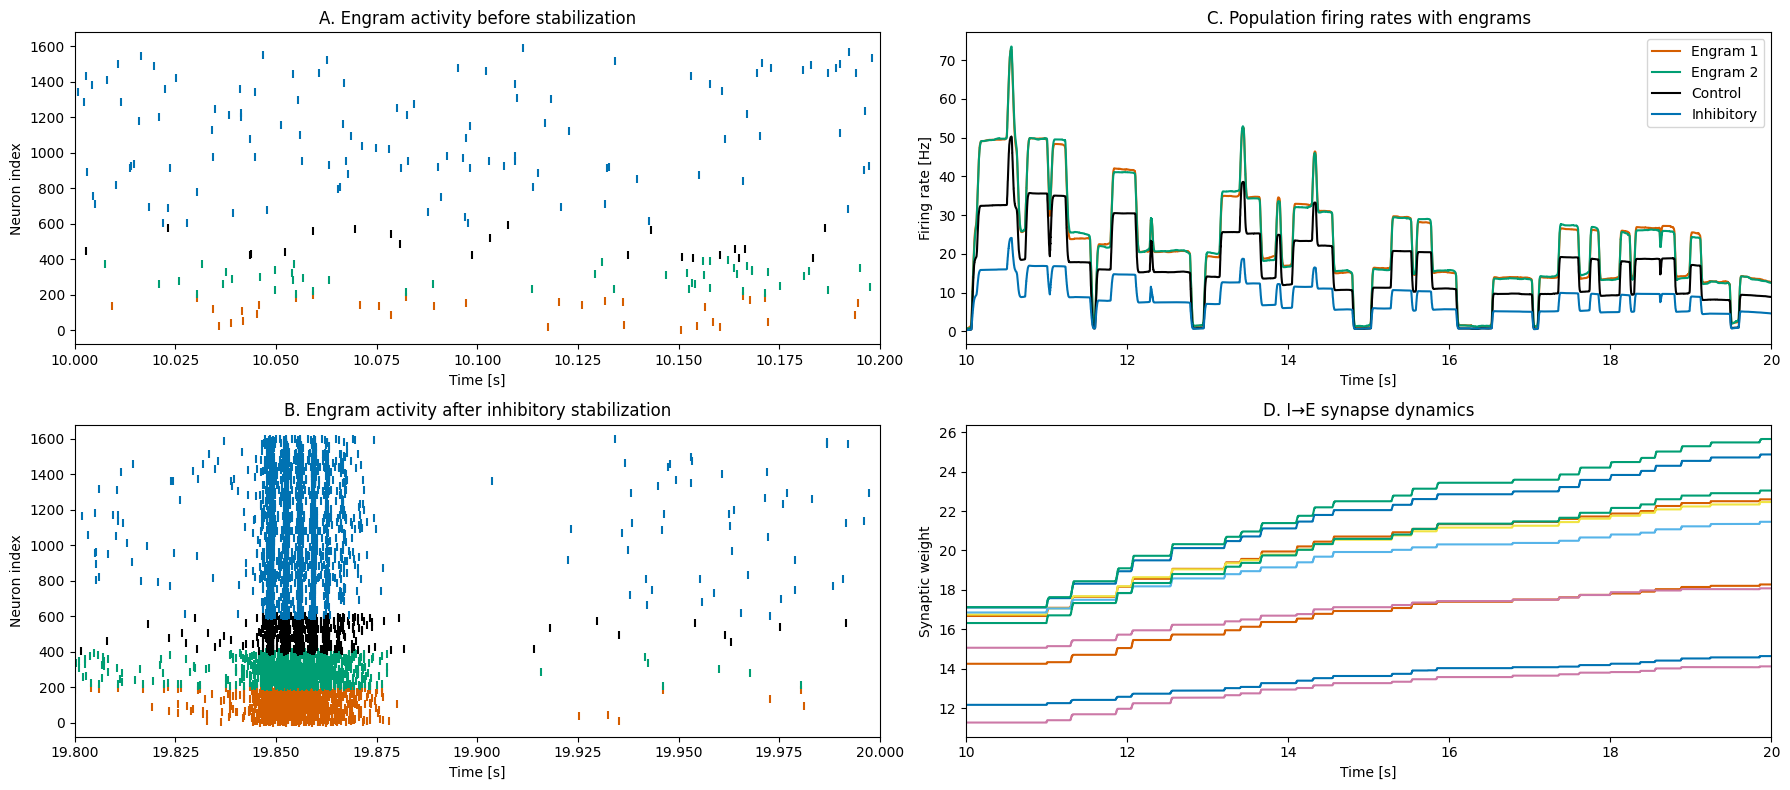

In [23]:
# Define neurons to include in the engrams
engram_1 = np.arange(1800, 2000)
engram_2 = np.arange(1975, 2175)

# Pre-engram weight matrix
W_before = np.full((N_E + N_I, N_E + N_I), np.nan)
W_before[EE.i[:], EE.j[:]] = EE.w[:]
W_before[II.i[:] + N_E, II.j[:] + N_E] = II.w[:] * -1
W_before[IE.i[:] + N_E, IE.j[:]] = IE.w[:] * -1

# Strengthen weights for engram assemblies
factor = 5
EE.w[engram_1, engram_1] = factor
EE.w[engram_2, engram_2] = factor

# Save post-engram weight matrix
W_after = np.full((N_E + N_I, N_E + N_I), np.nan)
W_after[EE.i[:], EE.j[:]] = EE.w[:]
W_after[II.i[:] + N_E, II.j[:] + N_E] = II.w[:] * -1
W_after[IE.i[:] + N_E, IE.j[:]] = IE.w[:] * -1

# Setup monitors 
s_E1 = SpikeMonitor(N_Pop[engram_1])
s_E2 = SpikeMonitor(N_Pop[engram_2])
s_Ec = SpikeMonitor(N_Pop[np.arange(engram_1.shape[0], dtype=int)])
s_I = SpikeMonitor(N_Pop[N_E:])

r_E1 = PopulationRateMonitor(N_Pop[engram_1])
r_E2 = PopulationRateMonitor(N_Pop[engram_2])
r_Ec = PopulationRateMonitor(N_Pop[np.arange(engram_1.shape[0], dtype=int)])
r_I = PopulationRateMonitor(N_Pop[N_E:])

ws = StateMonitor(IE, ['w'], record=np.arange(10), dt=1 * ms)

# Phase 1: Run network with engram but without plasticity
eta = 0
run(1 * second, report='text')

# Phase 2: Plasticity on
eta = 0.01
run(9 * second, report='text')

# Visualization

fig, ax = plt.subplots(2, 2, figsize=(18, 8))

# Raster plots
ax[0, 0].scatter(s_E1.t, s_E1.i, color=palette[2], marker='|')
ax[0, 0].scatter(s_E2.t, s_E2.i + len(engram_1), color=palette[1], marker='|')
ax[0, 0].scatter(s_Ec.t, s_Ec.i + len(engram_1) + len(engram_2), color='k', marker='|')
ax[0, 0].scatter(s_I.t, s_I.i + len(engram_1)*2 + len(engram_2), color=palette[0], marker='|')
ax[0, 0].set_xlim(10, 10.2)
ax[0, 0].set_xlabel('Time [s]')
ax[0, 0].set_ylabel('Neuron index')
ax[0, 0].set_title('A. Engram activity before stabilization')

ax[1, 0].scatter(s_E1.t, s_E1.i, color=palette[2], marker='|')
ax[1, 0].scatter(s_E2.t, s_E2.i + len(engram_1), color=palette[1], marker='|')
ax[1, 0].scatter(s_Ec.t, s_Ec.i + len(engram_1) + len(engram_2), color='k', marker='|')
ax[1, 0].scatter(s_I.t, s_I.i + len(engram_1)*2 + len(engram_2), color=palette[0], marker='|')
ax[1, 0].set_xlim(19.8, 20)
ax[1, 0].set_xlabel('Time [s]')
ax[1, 0].set_ylabel('Neuron index')
ax[1, 0].set_title('B. Engram activity after inhibitory stabilization')

# Firing rates
ax[0, 1].plot(r_E1.t / second, r_E1.smooth_rate(window='flat', width=0.5 * second) / Hz, color=palette[2], label='Engram 1')
ax[0, 1].plot(r_E2.t / second, r_E2.smooth_rate(window='flat', width=0.5 * second) / Hz, color=palette[1], label='Engram 2')
ax[0, 1].plot(r_Ec.t / second, r_Ec.smooth_rate(window='flat', width=0.5 * second) / Hz, color='k', label='Control')
ax[0, 1].plot(r_I.t / second, r_I.smooth_rate(window='flat', width=0.5 * second) / Hz, color=palette[0], label='Inhibitory')
ax[0, 1].legend()
ax[0, 1].set_xlim(10, 20)
ax[0, 1].set_xlabel('Time [s]')
ax[0, 1].set_ylabel('Firing rate [Hz]')
ax[0, 1].set_title('C. Population firing rates with engrams')

# Weight evolution
for i in range(10):
    ax[1, 1].plot(ws.t / second, ws.w[i])
ax[1, 1].axvline(1, ls=':', c='grey', label='Plasticity onset')
ax[1, 1].set_xlim(10, 20)
ax[1, 1].set_xlabel('Time [s]')
ax[1, 1].set_ylabel('Synaptic weight')
ax[1, 1].set_title('D. I→E synapse dynamics')

fig.tight_layout()
plt.show()

### 5.3. Reactivation of "silent" engrams

After inhibitory plasticity stabilizes the network and suppresses spontaneous reverberations, the memory engrams are still embedded in the strengthened excitatory weights.

This raises an important question:

_Can these "silent" engrams be selectively reactivated by an external stimulus?_

To test this, we apply a weak constant input current to a subset of neurons in ```engram_1```, to model partial reactivation of the network. We then want to see if the network reactivates the full assembly in response, meaning it supports **pattern completion**, a hallmark of associative memory. 

Starting simulation at t=302. s for a duration of 1. s
1. s (100%) simulated in 1s


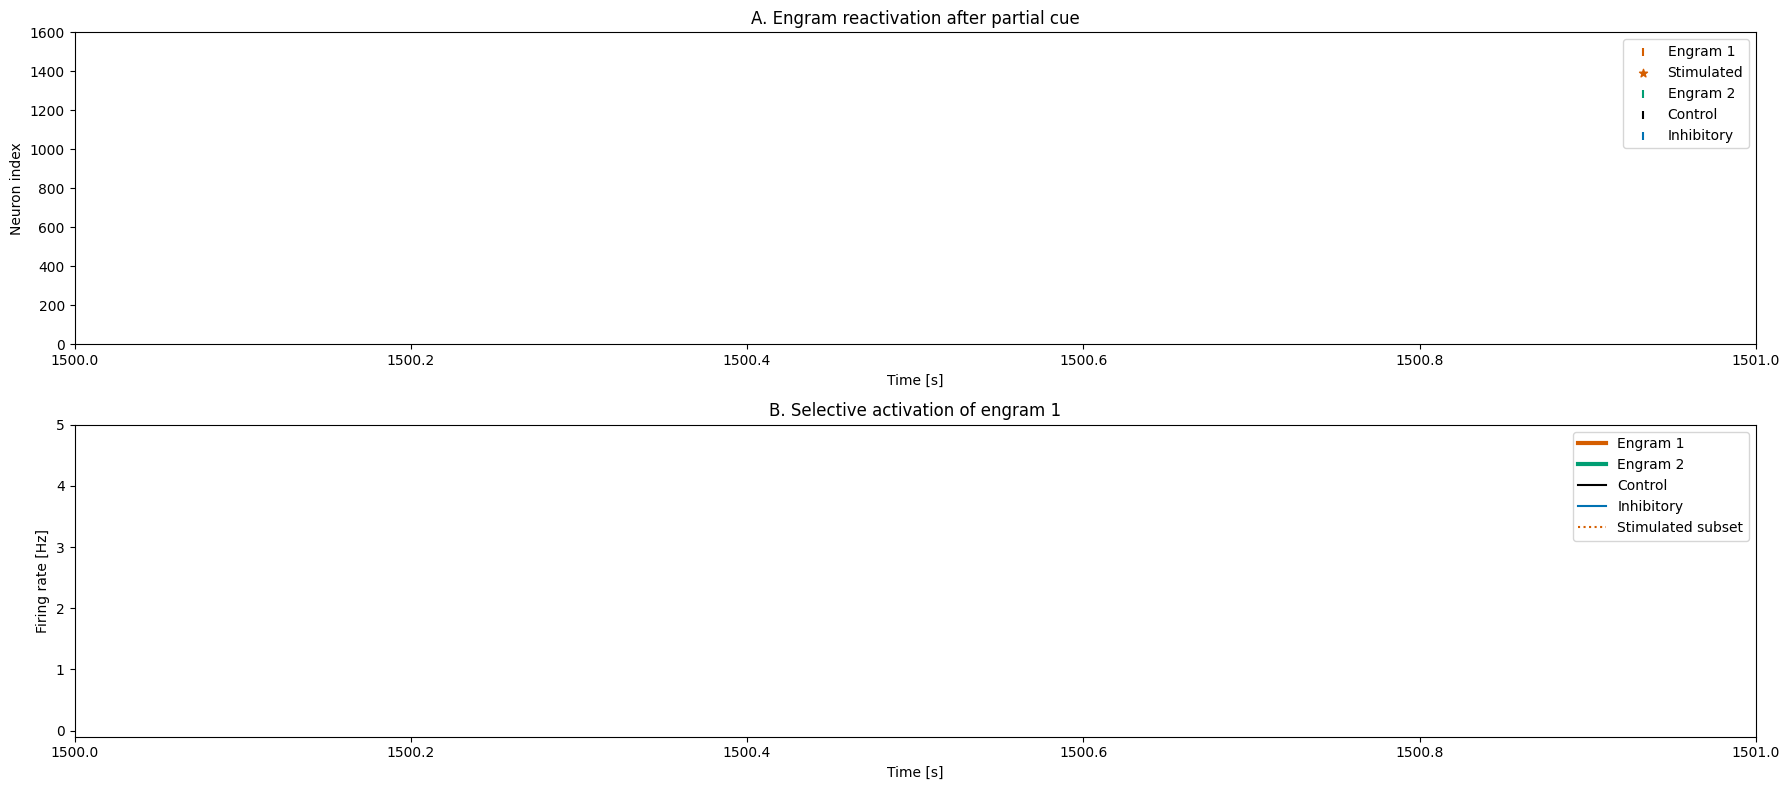

In [ ]:
# Clean up

del s_E1, s_E2, s_Ec, s_I
del r_E1, r_E2, r_Ec, r_I
del ws

# Restore trained network state
restore(filename='stored_networks/trained_network')

# Set up monitors again
s_E1 = SpikeMonitor(N_Pop[engram_1])
s_E2 = SpikeMonitor(N_Pop[engram_2])
s_Ec = SpikeMonitor(N_Pop[np.arange(engram_1.shape[0], dtype=int)])
s_I = SpikeMonitor(N_Pop[N_E:])

r_E1 = PopulationRateMonitor(N_Pop[engram_1])
r_E2 = PopulationRateMonitor(N_Pop[engram_2])
r_Ec = PopulationRateMonitor(N_Pop[np.arange(engram_1.shape[0], dtype=int)])
r_I = PopulationRateMonitor(N_Pop[N_E:])

# Subset of engram_1 to stimulate
size_stim = 25
stim_targets = engram_1[:size_stim]
N_Pop.I_e[stim_targets] = 30 * pA

# Additional monitors for stimulated subset
eta = 0  # plasticity remains off
r_stimmed = PopulationRateMonitor(N_Pop[stim_targets])
s_stimmed = SpikeMonitor(N_Pop[stim_targets])

# ----------------------------
# Run reactivation test
# ----------------------------
run(1 * second, report='text')

# ----------------------------
# Plot reactivation
# ----------------------------
fig, ax = plt.subplots(2, 1, figsize=(18, 8))

# Raster plot with highlighted stimulated neurons
ax[0].scatter(s_E1.t, s_E1.i, color=palette[2], marker='|', label='Engram 1')
ax[0].scatter(s_stimmed.t, s_stimmed.i, color=palette[2], marker='*', label='Stimulated')
ax[0].scatter(s_E2.t, s_E2.i + len(engram_1), color=palette[1], marker='|', label='Engram 2')
ax[0].scatter(s_Ec.t, s_Ec.i + len(engram_1) + len(engram_2), color='k', marker='|', label='Control')
ax[0].scatter(s_I.t, s_I.i + len(engram_1)*2 + len(engram_2), color=palette[0], marker='|', label='Inhibitory')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Neuron index')
ax[0].set_xlim(1500, 1501)
ax[0].set_ylim(0, 1600)
ax[0].set_title('A. Engram reactivation after partial cue')
ax[0].legend(loc='upper right')

# Population rates showing selective activation
ax[1].plot(r_E1.t / second, r_E1.smooth_rate(window='flat', width=0.5 * second) / Hz, color=palette[2], label='Engram 1', linewidth=3)
ax[1].plot(r_E2.t / second, r_E2.smooth_rate(window='flat', width=0.5 * second) / Hz, color=palette[1], label='Engram 2', linewidth=3)
ax[1].plot(r_Ec.t / second, r_Ec.smooth_rate(window='flat', width=0.5 * second) / Hz, color='k', label='Control')
ax[1].plot(r_I.t / second, r_I.smooth_rate(window='flat', width=0.5 * second) / Hz, color=palette[0], label='Inhibitory')
ax[1].plot(r_stimmed.t / second, r_stimmed.smooth_rate(window='flat', width=0.5 * second) / Hz, color=palette[2], linestyle=':', label='Stimulated subset')
ax[1].set_xlim(1500, 1501)
ax[1].set_ylim(-0.1, 5)
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Firing rate [Hz]')
ax[1].set_title('B. Selective activation of engram 1')
ax[1].legend()

fig.tight_layout()
plt.show()

**5.4 Stabilising inserted Memory engrams via inhibitory plasticity**

Now that the network is in a favourable activity regime, we want to use the network to store memory patterns. Therefore, we insert two (overlapping) memory engrams in the EE weights of our network. Therefore, the total strength of the excitatory synapses increase. 

![title](insert_engram_network.png)

*Note: Can you think of a way to learn such assemblies or memory engrams in a recurrent network?*


Our two cell assemblies are formed between Neurons 1500-1800 and 1700-2000:

In [35]:
W_before = np.full((N_E + N_I,N_E + N_I), np.nan)
W_before[EE.i[:],EE.j[:]] = EE.w[:]
W_before[II.i[:]+N_E,II.j[:]+N_E] = II.w[:] * -1
W_before[IE.i[:]+N_E,IE.j[:]] = IE.w[:] * -1

factor = 5 # increase of the engrams weights

EE.w[engram_1, engram_1] = factor
EE.w[engram_2, engram_2] = factor

W_after = np.full((N_E + N_I,N_E + N_I), np.nan)
W_after[EE.i[:],EE.j[:]] = EE.w[:]
W_after[II.i[:]+N_E,II.j[:]+N_E] = II.w[:] * -1
W_after[IE.i[:]+N_E,IE.j[:]] = IE.w[:] * -1

store(filename = 'stored_networks/inserted_engrams_EI_network')

Unfortunately, our weight matrix is too sparse to show any significant difference in the printed matrixes alone. Howver, we can check that the matrix insertion worked by calculating, the minimum, maximum and mean of the full weight matrix. After a successfull engram insertion these statistics should have changed (except the minimum).

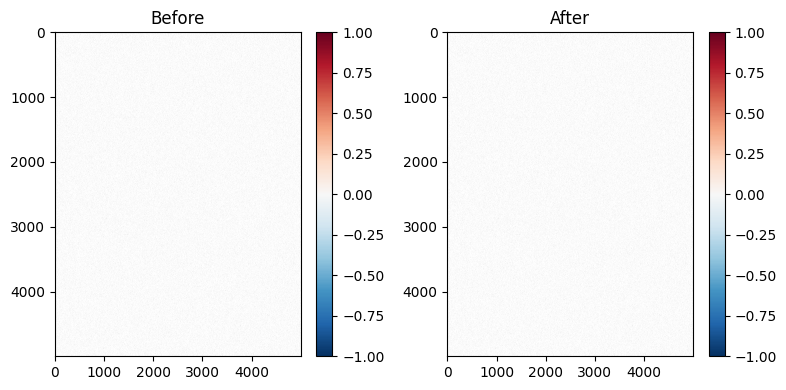

Before:
-0.8607976432251049
-32.51386200849779
1.0
After:
-0.8479706834620085
-32.51386200849779
5.0


In [31]:
fig, ax = subplots(1,2,figsize = (8,4))
hm = ax[0].imshow(W_before, cmap = 'RdBu_r', vmin = -1, vmax= 1, aspect = 'auto')
ax[0].set_title('Before')
fig.colorbar(hm, ax=ax[0])
hm2 = ax[1].imshow(W_after, cmap = 'RdBu_r', vmin = -1, vmax = 1, aspect = 'auto')
fig.colorbar(hm2, ax=ax[1])
ax[1].set_title('After')
fig.tight_layout()
plt.show()

print('Before:')
print(np.nanmean(W_before))
print(np.nanmin(W_before))
print(np.nanmax(W_before))

print('After:')
print(np.nanmean(W_after))
print(np.nanmin(W_after))
print(np.nanmax(W_after))

In [32]:
#setting up the monitors to record activity and weights
s_E1 = SpikeMonitor(N_Pop[engram_1])
s_E2 = SpikeMonitor(N_Pop[engram_2])
s_Ec = SpikeMonitor(N_Pop[np.arange(engram_1.shape[0], dtype = 'int')])
s_I = SpikeMonitor(N_Pop[N_E:])

r_E1 = PopulationRateMonitor(N_Pop[engram_1])
r_E2 = PopulationRateMonitor(N_Pop[engram_2])
r_Ec = PopulationRateMonitor(N_Pop[np.arange(engram_1.shape[0], dtype = 'int')])
r_I = PopulationRateMonitor(N_Pop[N_E:])

#record the IE weights
ws = StateMonitor(IE, ['w'], record = np.arange(10),dt = 1 * ms) #we only record 10 synapses to save on memory


#run the network without plasticity to see the shift in activity
eta = 0
run(1 * second, report = 'text')

#let the plasticity stabilise the network

eta = 0.01
run(9 * second,report = 'text')

Starting simulation at t=10. s for a duration of 1. s
1. s (100%) simulated in 1s
Starting simulation at t=11. s for a duration of 9. s
7.3261 s (81%) simulated in 10s, estimated 2s remaining.
9. s (100%) simulated in 12s


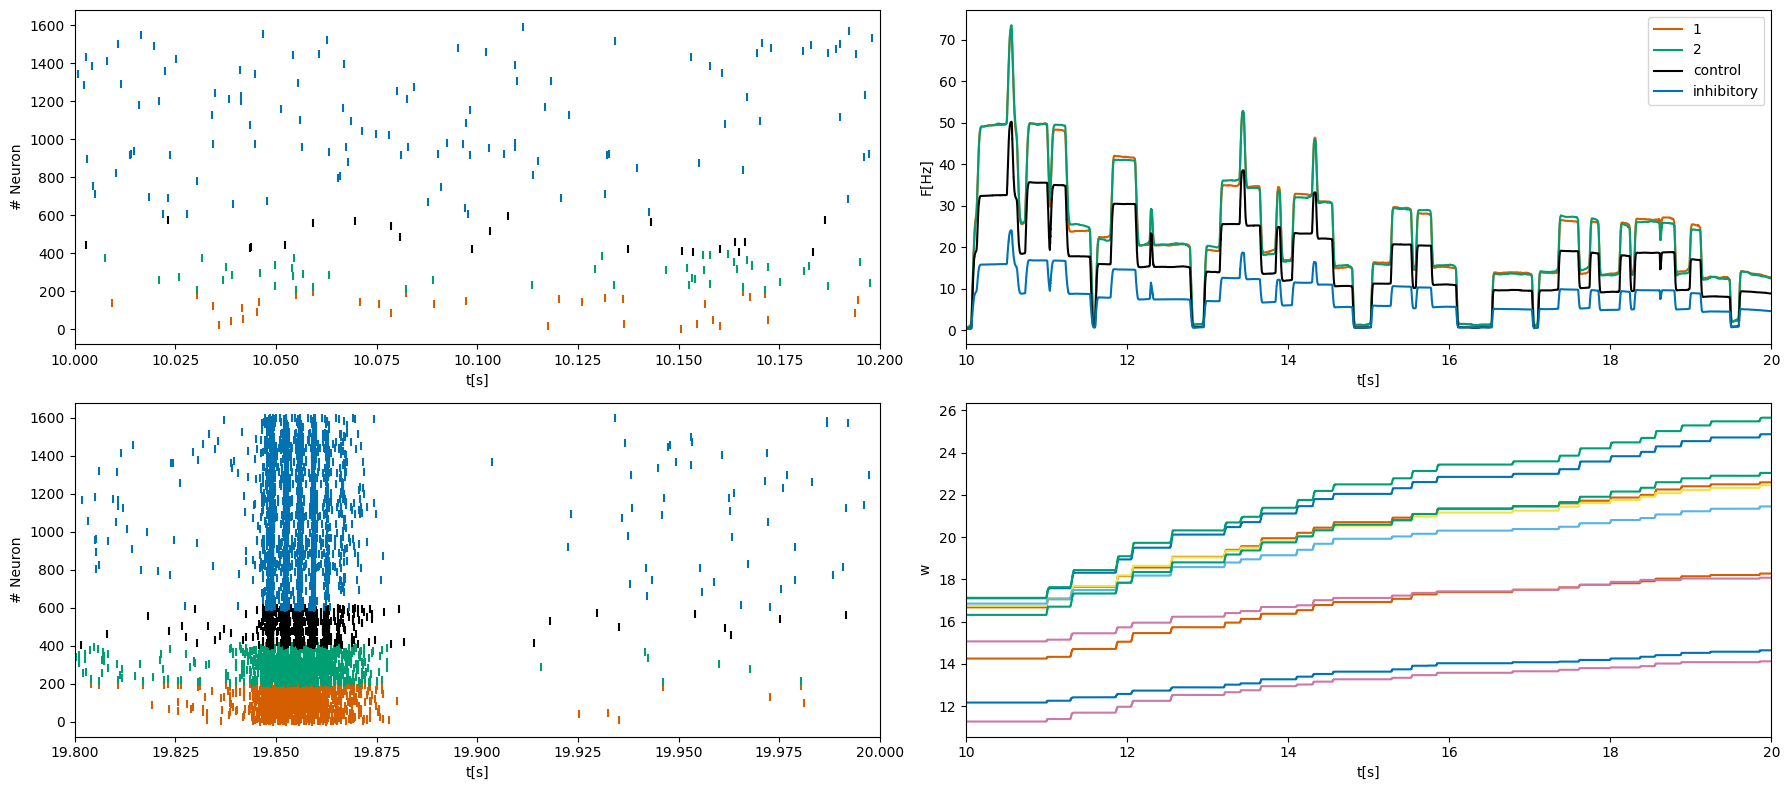

In [ ]:
#visualise the simulation results
fig, ax = plt.subplots(2,2,figsize=(18, 8))
ax[0,0].scatter(s_E1.t,s_E1.i, color = palette[2], marker = '|')
ax[0,0].scatter(s_E2.t,s_E2.i+(engram_1.shape[0]), color = palette[1], marker = '|')
ax[0,0].scatter(s_Ec.t,s_Ec.i+(engram_1.shape[0])+(engram_2.shape[0]), color = 'k', marker = '|')
ax[0,0].scatter(s_I.t, s_I.i+(engram_1.shape[0])+(engram_2.shape[0])+engram_1.shape[0], color = palette[0], marker = '|')
ax[0,0].set_xlabel('t[s]')
ax[0,0].set_ylabel('# Neuron')
ax[1,0].scatter(s_E1.t,s_E1.i, color = palette[2], marker = '|')
ax[1,0].scatter(s_E2.t,s_E2.i+(engram_1.shape[0]), color = palette[1], marker = '|')
ax[1,0].scatter(s_Ec.t,s_Ec.i+(engram_1.shape[0])+(engram_2.shape[0]), color = 'k', marker = '|')
ax[1,0].scatter(s_I.t, s_I.i+(engram_1.shape[0])+(engram_2.shape[0])+engram_1.shape[0], color = palette[0], marker = '|')

ax[1,0].set_xlabel('t[s]')
ax[1,0].set_ylabel('# Neuron')
ax[0,1].plot(r_E1.t/second, r_E1.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = palette[2], label = '1')
ax[0,1].plot(r_E2.t/second, r_E2.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = palette[1], label = '2')
ax[0,1].plot(r_Ec.t/second, r_Ec.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = 'k', label = 'control')
ax[0,1].plot(r_I.t/second, r_I.smooth_rate(window = 'flat', width = 0.5*second)/Hz, color = palette[0], label = 'inhibitory')
ax[0,1].legend()
ax[0,1].set_xlabel('t[s]')
ax[0,1].set_ylabel('F[Hz]')

for i in arange(10):
    ax[1,1].plot(ws.t/second, ws.w[i])
ax[1,1].axvline(1, ls=':', c='grey')
ax[1,1].set_xlabel('t[s]')
ax[1,1].set_ylabel('w')

ax[0,0].set_xlim(10,10.2)
ax[1,0].set_xlim(19.8,20)
ax[0,1].set_xlim(10,20)
ax[1,1].set_xlim(10,20)

fig.tight_layout()
plt.show()


In [32]:
########################################################
# DO NOT RUN THIS CELL DURING THE (in-person) TUTORIAL #
########################################################

# run(280 * second, report = 'text')

# IE_to_store = np.full((N_I,N_E), np.nan)
# IE_to_store[IE.i[:],IE.j[:]] = IE.w[:]

# np.save('stored_networks/IE_training_weights.npy', IE_to_store)


store(filename = 'stored_networks/training_network')

Due to the runtime for simulating the network for 280s, we will restore the network to a previously safed version. This is the network state after running it for 280s. 

If you have enough time left, you can uncomment all code above and comment out the following cell with the *restore()* command. Execution time of the 280s simulation is roughly 10-15min. 

In [ ]:
restore(filename = 'stored_networks/training_network')

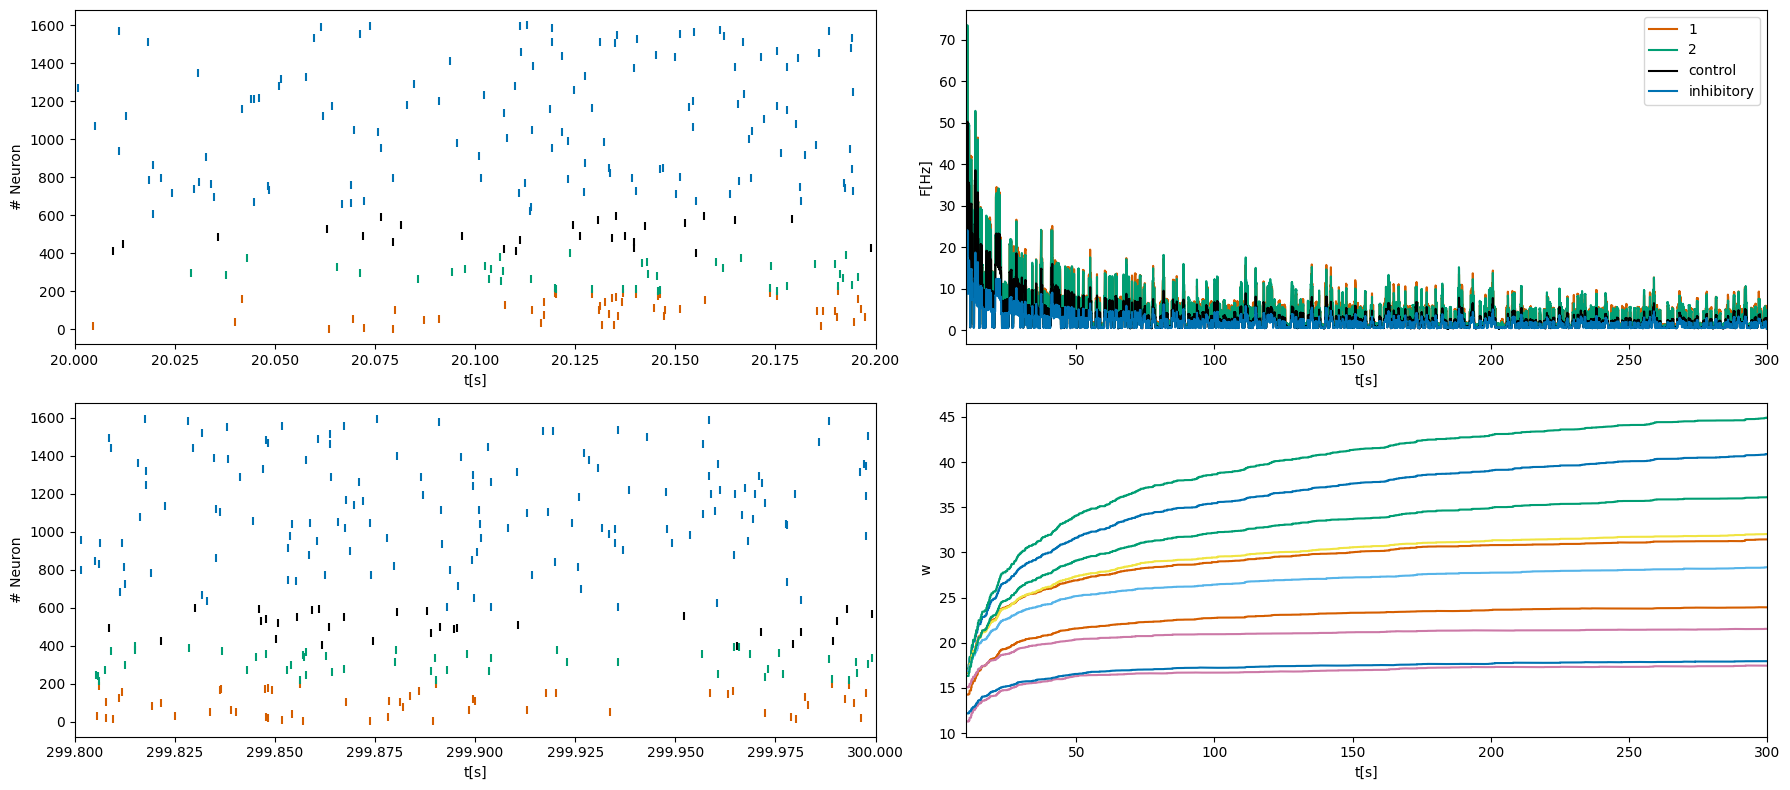

In [ ]:
#visualise the simulation results
fig, ax = plt.subplots(2,2,figsize=(18, 8))
ax[0,0].scatter(s_E1.t,s_E1.i, color = palette[2], marker = '|')
ax[0,0].scatter(s_E2.t,s_E2.i+(engram_1.shape[0]), color = palette[1], marker = '|')
ax[0,0].scatter(s_Ec.t,s_Ec.i+(engram_1.shape[0])+(engram_2.shape[0]), color = 'k', marker = '|')
ax[0,0].scatter(s_I.t, s_I.i+(engram_1.shape[0])+(engram_2.shape[0])+engram_1.shape[0], color = palette[0], marker = '|')
ax[0,0].set_xlabel('t[s]')
ax[0,0].set_ylabel('# Neuron')
ax[1,0].scatter(s_E1.t,s_E1.i, color = palette[2], marker = '|')
ax[1,0].scatter(s_E2.t,s_E2.i+(engram_1.shape[0]), color = palette[1], marker = '|')
ax[1,0].scatter(s_Ec.t,s_Ec.i+(engram_1.shape[0])+(engram_2.shape[0]), color = 'k', marker = '|')
ax[1,0].scatter(s_I.t, s_I.i+(engram_1.shape[0])+(engram_2.shape[0])+engram_1.shape[0], color = palette[0], marker = '|')

ax[1,0].set_xlabel('t[s]')
ax[1,0].set_ylabel('# Neuron')
ax[0,1].plot(r_E1.t/second, r_E1.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = palette[2], label = '1')
ax[0,1].plot(r_E2.t/second, r_E2.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = palette[1], label = '2')
ax[0,1].plot(r_Ec.t/second, r_Ec.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = 'k', label = 'control')
ax[0,1].plot(r_I.t/second, r_I.smooth_rate(window = 'flat', width = 0.5*second)/Hz, color = palette[0], label = 'inhibitory')
ax[0,1].legend()
ax[0,1].set_xlabel('t[s]')
ax[0,1].set_ylabel('F[Hz]')

for i in arange(10):
    ax[1,1].plot(ws.t/second, ws.w[i])
ax[1,1].axvline(1, ls=':', c='grey')
ax[1,1].set_xlabel('t[s]')
ax[1,1].set_ylabel('w')

ax[0,0].set_xlim(20,20.2)
ax[1,0].set_xlim(299.8,300)
ax[0,1].set_xlim(10,300)
ax[1,1].set_xlim(10,300)

fig.tight_layout()
plt.show()


The events which still need to stabilise are the spontaneous self-activations of the engram which surge through the full network. These drive short periods of synchronous activity. We run the network for another 200s so that it can settle into a state without these engram reverberations (spontaneous reactivations).

Tip: If you want to have a closer look at the preceeding spiking dynamics of spontaneous reactivation, you can find them at strong increases in the rate of the control group. Set the spike raster on top to these time windows to have a closer look at the events.

In [36]:
#####################################
#DO NOT RUN THIS CELL DURING THE (in-person) TUTORIAL
#####################################

##we dont want to record the activity here, to save space and compute we delete all monitors
#del s_E1,s_E2, s_Ec, s_I
#del r_E1,r_E2, r_Ec, r_I
#del ws


run(1200 * second, report = 'text')

IE_to_store = np.full((N_I,N_E), np.nan)
IE_to_store[IE.i[:],IE.j[:]] = IE.w[:]

np.save('stored_networks/IE_trained_weights.npy', IE_to_store)

store(filename = 'stored_networks/trained_network')

Starting simulation at t=303. s for a duration of 1.2 ks
6.9846 s (0%) simulated in 10s, estimated 28m 28s remaining.
13.959 s (1%) simulated in 20s, estimated 28m 19s remaining.
20.8625 s (1%) simulated in 30s, estimated 28m 16s remaining.
27.7649 s (2%) simulated in 40s, estimated 28m 9s remaining.
34.7013 s (2%) simulated in 50s, estimated 27m 59s remaining.
41.4961 s (3%) simulated in 1m 0s, estimated 27m 55s remaining.
48.4453 s (4%) simulated in 1m 10s, estimated 27m 44s remaining.
55.3906 s (4%) simulated in 1m 20s, estimated 27m 33s remaining.


KeyboardInterrupt: 

*Note:* Due to the long run time of the cell above (~30 min), we will load pretrained weights. You can train the network yourself, if you want to play around with the training time.


**5.5 Engram reactivation**

![title](reactivation_network.png)

After stabilising the network activity via inhibitory plasticity, the network still encodes the engrams in its excitatory weights. Spontaneous activity in the network does not show a footprint of the memories anymore. But we can try to reactivate them with a partial stimulus. The stimulus in form of an external constant current is delivered to a subgroup of the engram neurons. 

In [ ]:
del s_E1,s_E2, s_Ec, s_I
del r_E1,r_E2, r_Ec, r_I
del ws

restore(filename = 'stored_networks/trained_network')

#setting up the monitors to record activity and weights
s_E1 = SpikeMonitor(N_Pop[engram_1])
s_E2 = SpikeMonitor(N_Pop[engram_2])
s_Ec = SpikeMonitor(N_Pop[np.arange(engram_1.shape[0], dtype = 'int')])
s_I = SpikeMonitor(N_Pop[N_E:])

r_E1 = PopulationRateMonitor(N_Pop[engram_1])
r_E2 = PopulationRateMonitor(N_Pop[engram_2])
r_Ec = PopulationRateMonitor(N_Pop[np.arange(engram_1.shape[0], dtype = 'int')])
r_I = PopulationRateMonitor(N_Pop[N_E:])


In [ ]:
size_stim = 25 #neuron, maximally 200 (engram_1.shape[0])

N_Pop.I_e[engram_1[:size_stim]] = 30 * pA  #a subpopulation of the 1st engram is receiving an additional current (constant)
eta = 0
r_stimmed = PopulationRateMonitor(N_Pop[engram_1[:size_stim]])
s_stimmed = SpikeMonitor(N_Pop[engram_1[:size_stim]])

run(1 * second, report = 'text')


building '_cython_magic_4e5399d56529119c96cd0d51547a7cca' extension
INFO: C compiler: x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC

INFO: compile options: '-I/usr/include -I/home/patricia/.local/lib/python3.10/site-packages/numpy/core/include -I/home/patricia/.local/lib/python3.10/site-packages/brian2/synapses -I/usr/include/python3.10 -c'
extra options: '-w -O3 -ffast-math -fno-finite-math-only -march=native -std=c++11'
INFO: x86_64-linux-gnu-gcc: /home/patricia/.cython/brian_extensions/_cython_magic_4e5399d56529119c96cd0d51547a7cca.cpp
INFO: x86_64-linux-gnu-g++ -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -g -fwrapv -O2 /home/patricia/.cython/brian_extensions/home/patricia/.cython/brian_extensions/_cython_magic_4e5399d56529119c96cd0d51547a7cca.o -L/usr/lib -L/usr/lib/x86_64-linux-gnu -Wl,--enable-new-dtags,-R/usr/lib -o /home/patricia/.cython

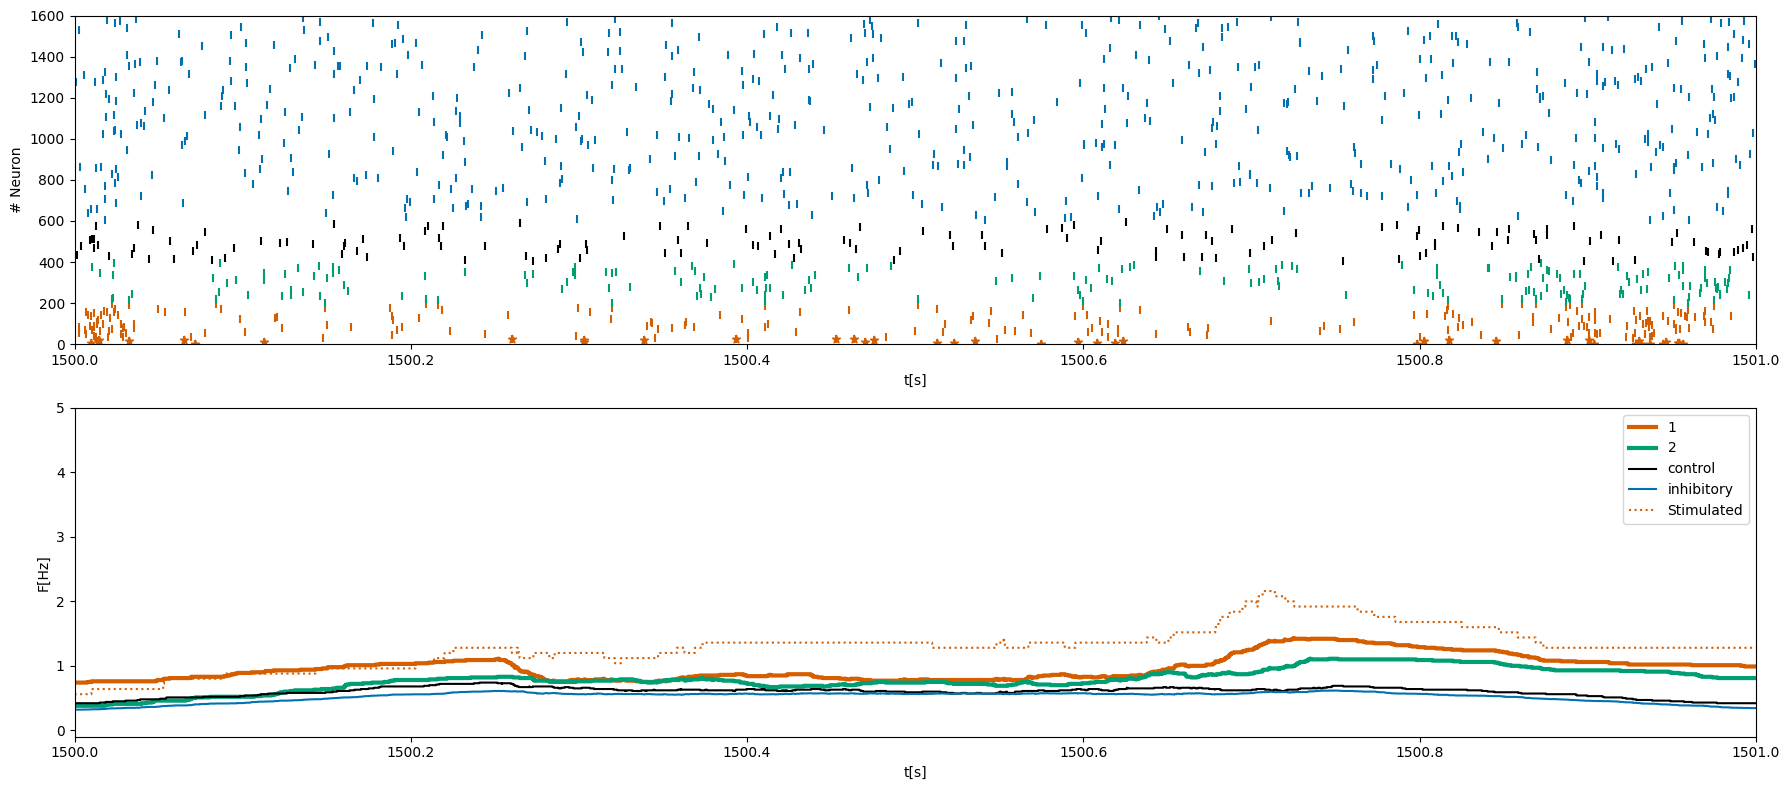

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(18, 8))
ax[0].scatter(s_E1.t,s_E1.i, color = palette[2], marker = '|')
ax[0].scatter(s_stimmed.t,s_stimmed.i, color = palette[2], marker = '*')
ax[0].scatter(s_E2.t,s_E2.i+(engram_1.shape[0]), color = palette[1], marker = '|')
ax[0].scatter(s_Ec.t,s_Ec.i+(engram_1.shape[0])+(engram_2.shape[0]), color = 'k', marker = '|')
ax[0].scatter(s_I.t, s_I.i+(engram_1.shape[0])+(engram_2.shape[0])+engram_1.shape[0], color = palette[0], marker = '|')
ax[0].set_xlabel('t[s]')
ax[0].set_ylabel('# Neuron')

ax[1].plot(r_E1.t/second, r_E1.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = palette[2], label = '1', linewidth = 3)
ax[1].plot(r_E2.t/second, r_E2.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = palette[1], label = '2', linewidth = 3)
ax[1].plot(r_Ec.t/second, r_Ec.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = 'k', label = 'control')
ax[1].plot(r_I.t/second, r_I.smooth_rate(window = 'flat', width = 0.5*second)/Hz, color = palette[0], label = 'inhibitory')
ax[1].plot(r_stimmed.t/second, r_stimmed.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = palette[2], linestyle = ':', label = 'Stimulated')
ax[1].legend()
ax[1].set_xlabel('t[s]')
ax[1].set_ylabel('F[Hz]')


ax[0].set_xlim(1500,1501)
ax[1].set_xlim(1500,1501)
ax[1].set_ylim(-0.1, 5)
ax[0].set_ylim(0,1600)

fig.tight_layout()
plt.show()